# Predicting the number of rebar in an image
After training the model, we can use it to predict the number of rebar in an image.
We will conduct a hyperparameter tuning on the threshold to get the best MSE.

In [1]:
import os
import torch
import torchvision
from PIL import Image
import pytorch_lightning as pl
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from transformers import DetrForObjectDetection, DetrFeatureExtractor
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Load the model
We will use the model trained in the previous notebook. We need to load it as well as sprecifying the architecture of the model.

In [2]:
# Create the Data loader to train the model
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, mode='train'):
        assert mode in ['train', 'val', 'test'],  f'Unknown mode: {mode}'
        ann_file = os.path.join(img_folder, f"annotations/{mode}.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target


# We define our model based on DETR
class Detr(pl.LightningModule):

     def __init__(self, lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4, num_queries=500, num_labels=2, pretrained_model="facebook/detr-resnet-50"):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = DetrForObjectDetection.from_pretrained(pretrained_model, 
                                                             num_labels=num_labels,
                                                             num_queries=num_queries,
                                                             ignore_mismatched_sizes=True)
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer
     # This part is not needed since we are not training the model
     # 
     # def train_dataloader(self):
     #    return train_dataloader
     # 
     # def val_dataloader(self):
     #    return val_dataloader

In [3]:
# Read the model from file
model1 = Detr
model = Detr.load_from_checkpoint("./model/detr.ckpt")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# Set up the device
model.to(device)
model.eval()

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256

In [4]:
# Set up pre-trained model
pretrained_model = "facebook/detr-resnet-50"
img_folder = "RebarDSC/images"

feature_extractor = DetrFeatureExtractor.from_pretrained(pretrained_model)
val_dataset = CocoDetection(img_folder=f'{img_folder}', feature_extractor=feature_extractor, mode='val')
test_dataset = CocoDetection(img_folder=f'{img_folder}', feature_extractor=feature_extractor, mode='test')
train_dataset = CocoDetection(img_folder=f'{img_folder}', feature_extractor=feature_extractor, mode='train')

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


## Visualize a prediction to have a look to the model performance

torch.Size([1, 3, 800, 1066])


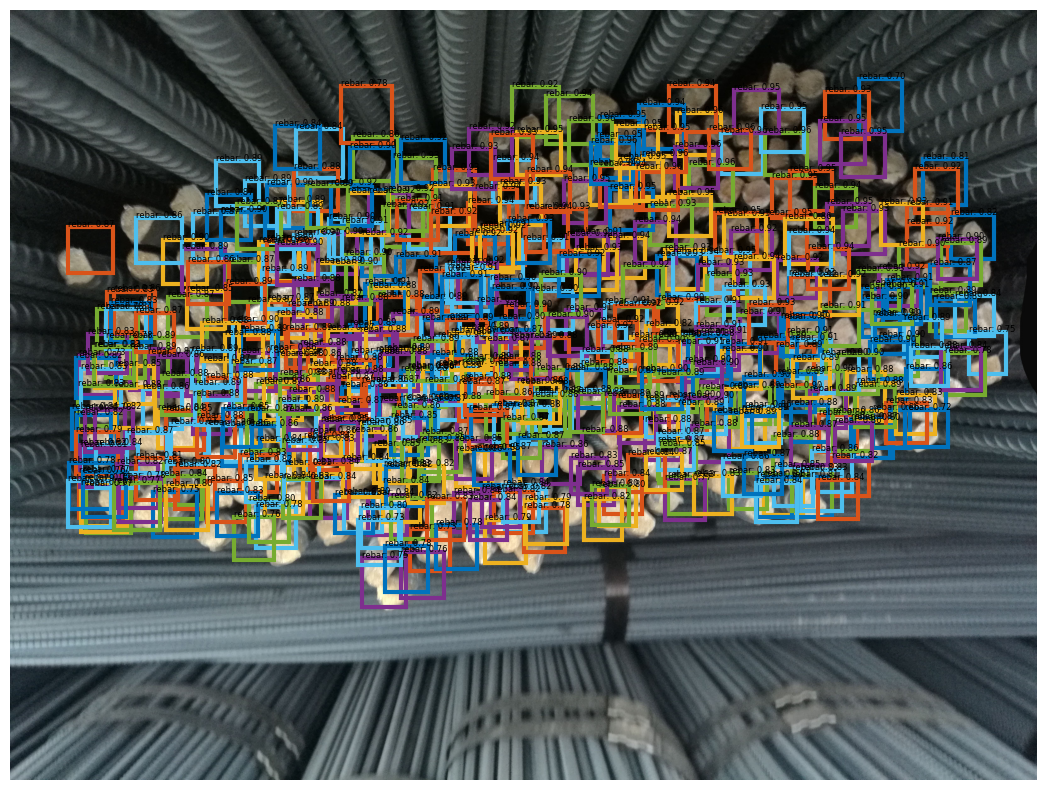

In [17]:
id2label = {1: "rebar", 0: "no_rebar"}

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=6)

    plt.axis('off')
    plt.show()
    
def visualize_predictions(image, outputs, threshold=0.9, keep_highest_scoring_bbox=False):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  if keep_highest_scoring_bbox:
    keep = probas.max(-1).values.argmax()
    keep = torch.tensor([keep])
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)
    
  # plot results
  plot_results(image, probas[keep], bboxes_scaled)
  
it = iter(range(1500))


#We can use the image_id in target to know which image it is
pixel_values, target = test_dataset[next(it)]

pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

# forward pass to get class logits and bounding boxes
outputs = model(pixel_values=pixel_values, pixel_mask=None)

image_id = target['image_id'].item()
image = test_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{img_folder}', image['file_name']))

visualize_predictions(image, outputs, threshold=0.7, keep_highest_scoring_bbox=False)

We can see that the model is able to detect the rebars in the image. However, the model is not able to count the number of rebars in the image. We will use the validation set to perform a parameter tuning on the threshold to get the best RMSE.

## Hyperparameter tuning
Since the model is taking more than 3 hours to train, we will use the validation set to perform a parameter tuning on the threshold to get the best MSE.
This is a good practice to avoid overfitting the test set, and also a good compromise between the time spent training and the accuracy of the model.

When counting the number of rebars in a picture, we are using image processing or machine learning algorithm. The best metric to measure error will depend on the specific nature of our task, but here are a few options:

- Mean Absolute Error (MAE): This is the average of the absolute differences between the predicted and actual values. It's a straightforward metric that gives us a raw measure of the error. However, it doesn't give us any insight into whether our model is systematically overestimating or underestimating the counts.

- Mean Squared Error (MSE): This is the average of the squares of the differences between the predicted and actual values. It penalizes larger errors more than smaller ones, so it's a good choice if we want to avoid large errors.

- Root Mean Squared Error (RMSE): This is the square root of the MSE. It has the same units as the original values, which can make it easier to interpret than the MSE.

- Mean Absolute Percentage Error (MAPE): This is the average of the absolute differences between the predicted and actual values, expressed as a percentage of the actual values. This can be a good choice if we want a relative measure of the error.

- Confusion Matrix and Derived Metrics (Precision, Recall, F1-score): If we are treating the task as a binary classification problem (rebar vs. no rebar), we could use a confusion matrix to look at the true positives, true negatives, false positives, and false negatives. Derived metrics like precision (how many selected items are relevant), recall (how many relevant items are selected), and the F1 score (harmonic mean of precision and recall) can provide more nuanced information about our model's performance.

- Intersection over Union (IoU): This is a measure of the overlap between the predicted and actual regions. It's often used in image segmentation tasks, which could be similar to our task if we're identifying the areas of the image that contain rebars.

For this project, we will use the RMSE as our metric.

In [5]:
def count_rebar(outputs, threshold=0.7):
  # keep only predictions with confidence >= threshold
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

  # return the count of rebar
    return len(probas[keep])

In [13]:
# Perform a parameter tuning on the threshold to get the best MSE
def get_RMSE(threshold, mode="val"):
    pred_res = pd.DataFrame(columns=["image_id", "pred_count", "act_count"])
    if mode == "val":
        dataset = val_dataset
    elif mode == "test":
        dataset = test_dataset
    elif mode == "train":
        dataset = train_dataset
    else:
        raise ValueError("Unknown mode")
    
    for it in iter(range(len(dataset))):
        if it % 50 == 0:
            # Print the progress
            clear_output(wait=True)
            print(f'{it}/{len(dataset)}')

        pixel_values, target = dataset[it]
        act_count = target['class_labels'].sum().tolist()
        
        pixel_values = pixel_values.unsqueeze(0).to(device)
        outputs = model(pixel_values=pixel_values, pixel_mask=None)
        image_id = target['image_id'].item()
        pred_count = count_rebar(outputs, threshold=threshold)
        
        pred_res.loc[len(pred_res)] = [image_id, pred_count, act_count]
        y_true = pred_res["act_count"]
        y_pred = pred_res["pred_count"]
        
    return [mean_squared_error(y_true, y_pred), mean_absolute_error(y_true, y_pred)], pred_res

In [7]:
# Perform a parameter tuning on the threshold to get the best MSE
thresholds = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99]
RMSEs = []
MAEs = []
for threshold in thresholds:
    res = get_RMSE(threshold, mode="val")
    RMSE = res[0][0]
    MAE = res[0][1]
    print(f"Threshold: {threshold}, RMSE: {RMSE}, MAE: {MAE}")
    RMSEs.append(RMSE)
    MAEs.append(MAE)

0/225
50/225
100/225
150/225
200/225
Threshold: 0.5, RMSE: 108905.2
Threshold: 0.5, MAE: 322.8088888888889
0/225
50/225
100/225
150/225
200/225
Threshold: 0.6, RMSE: 93260.42222222222
Threshold: 0.6, MAE: 295.4888888888889
0/225
50/225
100/225
150/225
200/225
Threshold: 0.7, RMSE: 67846.43111111112
Threshold: 0.7, MAE: 240.57333333333332
0/225
50/225
100/225
150/225
200/225
Threshold: 0.8, RMSE: 33583.497777777775
Threshold: 0.8, MAE: 154.4311111111111
0/225
50/225
100/225
150/225
200/225
Threshold: 0.85, RMSE: 18729.457777777778
Threshold: 0.85, MAE: 114.38222222222223
0/225
50/225
100/225
150/225
200/225
Threshold: 0.9, RMSE: 9478.36
Threshold: 0.9, MAE: 85.85333333333334
0/225
50/225
100/225
150/225
200/225
Threshold: 0.95, RMSE: 25661.324444444443
Threshold: 0.95, MAE: 146.14222222222222
0/225
50/225
100/225
150/225
200/225
Threshold: 0.99, RMSE: 31168.626666666667
Threshold: 0.99, MAE: 158.24444444444444


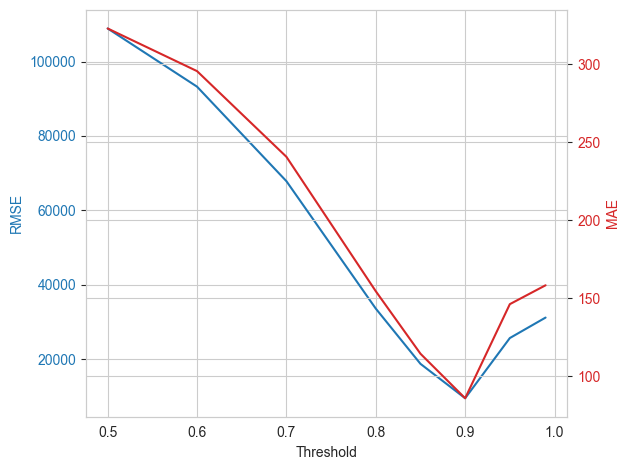

In [8]:
#Visualize the results (MAE and RMSE) of the parameter tuning
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('RMSE', color=color)
ax1.plot(thresholds, RMSEs, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('MAE', color=color)  # we already handled the x-label with ax1
ax2.plot(thresholds, MAEs, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [9]:
# Find the best threshold using RMSE
best_threshold = thresholds[RMSEs.index(min(RMSEs))]
print(f"Best threshold: {best_threshold}")

Best threshold: 0.9


In [14]:
# Get the MSE (Mean Squared Error)
results = get_RMSE(best_threshold, mode="test")
print("RMSE:", results[0][0])

RMSE: 10476.654


In [11]:
# View the prediction table
results[1]

,image_id,pred_count,act_count
0,1,150,245
1,3,0,46
2,5,133,232
3,9,28,199
4,16,281,272
...,...,...,...
995,2117,53,149
996,2118,458,280
997,2121,73,174
998,2123,421,266


## Build a naive model for comparison
We will build a naive model to compare the RMSE with our model.
The naive model will predict the average number of rebars in the training set for every image.

In [17]:
# Compare the RMSE to a naive model
results_train = get_RMSE(best_threshold, mode="train")
avg_count = results_train[1]["act_count"].mean()
print("RMSE naive:", mean_squared_error(results[1]["act_count"], [avg_count]*len(results[1])))

850/900
RMSE naive: 6289.704209382717


## Conclusion

Our analysis has yielded an RMSE that is not optimal, indicating that the current performance of our image processing model for counting the number of rebars is subpar. This outcome is likely attributable to the relatively brief training period we utilized, which consisted of only a few epochs. 

In the realm of machine learning, the process of training a model is an iterative one, and running a model through a limited number of epochs might not allow it to learn the underlying patterns in the data sufficiently. Consequently, the model's predictive accuracy may be compromised, as reflected in the high RMSE.

To improve our model's performance, we propose to extend the training duration. This would provide the model with additional opportunities to learn from the data and, potentially, yield a more accurate rebar count.

In addition to extending the training duration, it would be beneficial to conduct hyperparameter tuning. This involves systematically changing parameters like the learning rate, weight decay, and gradient clipping to find the combination that optimizes model performance:

- The learning rate controls the size of the adjustments made to the model's weights during training. An optimal learning rate would balance the need for the model to learn quickly, without overshooting the minimum of the loss function.

- Weight decay is a regularization technique that prevents the weights from becoming too large, which can lead to overfitting. By tuning this parameter, we can ensure that our model generalizes well to unseen data.

- Gradient clipping is a technique used to prevent exploding gradients, a problem where large gradient values cause a model to miss the minimum of the loss function. By tuning the clipping value, we can ensure that the gradients remain within a manageable range, enabling the model to learn effectively.

In summary, to enhance our model's performance, we suggest implementing a more extensive training period and conducting hyperparameter tuning for the learning rate, weight decay, and gradient clipping. This approach should lead to a significant reduction in the RMSE and, consequently, a more accurate count of rebars in images.